# How well can the trip waiting time be predicted 


This notebook presents a model to predict the waiting time in a taxi ride in Quito

## Data SET 
The used dataset contains date from Taxi rides in Quito  collected from June 2016 until July 20th 2017.  it's avable in https://www.kaggle.com/mnavas/taxi-routes-for-mexico-city-and-quito. 



In [215]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('uio_clean.csv')


df.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,32366.000000,32366.000000,32366.000000,32366.000000,32366.000000,3.236600e+04,3.236600e+04,3.236600e+04
mean,16183.500000,-78.492371,-0.189042,-78.492901,-0.191341,4.138239e+04,7.302745e+04,2.204058e+07
std,9343.403743,0.043108,0.076153,0.044783,0.085623,5.842226e+05,1.193671e+07,7.311736e+08
min,1.000000,-80.681697,-3.454279,-80.681721,-3.574739,-3.887110e+05,1.100000e+01,0.000000e+00
25%,8092.250000,-78.505867,-0.218344,-78.505734,-0.220508,5.000000e+02,2.148000e+03,1.070000e+02
50%,16183.500000,-78.490135,-0.181979,-78.490073,-0.185721,8.970000e+02,4.124000e+03,2.430000e+02
75%,24274.750000,-78.475783,-0.148715,-78.477443,-0.149867,1.710000e+03,7.475000e+03,4.990000e+02
max,32366.000000,-78.009669,0.866441,-77.710158,0.866759,7.002605e+07,2.147484e+09,9.516306e+10


**The data table description suggests that we have some discrepancy with respect to trip_duration , pickup_longitude , wait_sec **
There is negative values to  trip_duration 
The are values extremely high for trip duration, dist_meters, wait_sec, and latitudes. 

Let's investigate trip_duration,  wait_sec and dist_meters:




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  
/home/leo/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/leo/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


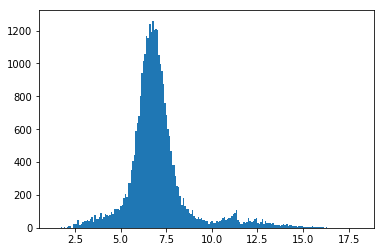

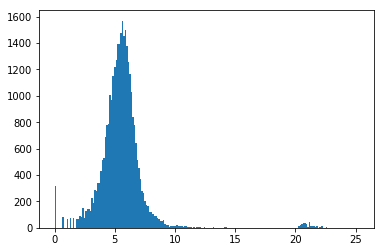

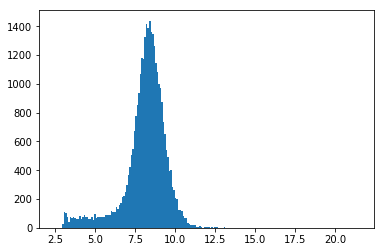

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


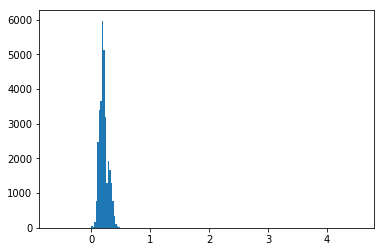

In [216]:
import matplotlib.pyplot as plt
y = np.log1p(df['trip_duration'])
plt.hist(y, bins=200) 
plt.show()

y = np.log1p(df['wait_sec'])
plt.hist(y, bins=200)  
plt.show()

y = np.log1p(df['dist_meters'])
plt.hist(y, bins=200)  
plt.show()

y = np.log1p(df['pickup_latitude'])
plt.hist(-y, bins=200)  
plt.show()




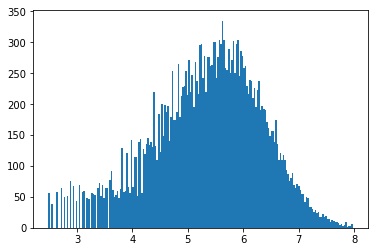

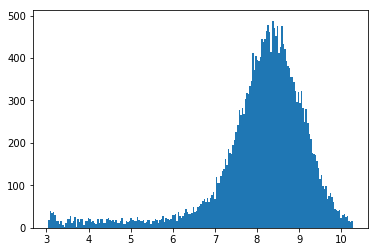

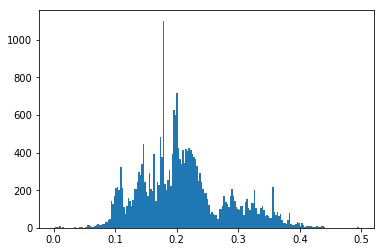

In [255]:
# base on the graph let's take off the  outliers

maxwait_sec = 2980 # e ^8 
maxTripDuration  = 2980 # e ^10 
maxDist=   162754 # e ^12 
minlatitude = -0.4
df=df.dropna()

df = df[(df['trip_duration'] > 10 )]
df=  df[(df['trip_duration'] < maxTripDuration )] 
df = df[df['wait_sec'] <=maxwait_sec ]
df = df[(df['wait_sec'] > 10 )]
df=  df[(df['dist_meters'] < maxDist )] 
df=  df[(df['pickup_latitude']< 0 )] 
df=  df[(df['pickup_latitude'] > minlatitude )] 
df=  df[(df['dropoff_latitude']< 0 )] 
df=  df[(df['dropoff_latitude'] > minlatitude )] 


#df=  df[(df['dropoff_latitude']> 0 )] 
#df=  df[(df['dropoff_latitude'] < minlatitude )] 



y = np.log1p(df['wait_sec'])
plt.hist(y, bins=200)  
plt.show()

y = np.log1p(df['dist_meters'])
plt.hist(y, bins=200)  
plt.show()


y = np.log1p(df['pickup_latitude'])
plt.hist(-y, bins=200)  
plt.show()

In [218]:

df.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,26374.000000,26374.000000,26374.000000,26374.000000,26374.000000,26374.000000,26374.000000,26374.000000
mean,16186.745431,-78.491625,-0.187565,-78.491973,-0.188970,935.233374,5089.956283,319.819709
std,9329.656349,0.028834,0.056775,0.029127,0.058027,629.842080,4821.716232,315.027013
min,1.000000,-79.167634,-0.397962,-79.198557,-0.388110,11.000000,20.000000,11.000000
25%,8151.250000,-78.505546,-0.215687,-78.504820,-0.217269,475.000000,2191.000000,110.000000
50%,16188.500000,-78.489971,-0.181802,-78.489823,-0.185432,785.000000,3909.000000,227.000000
75%,24305.500000,-78.475576,-0.149961,-78.477602,-0.151455,1261.000000,6555.750000,418.000000
max,32366.000000,-78.282944,-0.001295,-78.282557,-0.000558,2979.000000,148196.000000,2913.000000


In [219]:
## For the trafic the time and the day of week are important information 
#
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y/%m/%d %H:%M:%S')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
df.loc[:, 'month'] = df['pickup_datetime'].dt.month
df.loc[:, 'hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'week_of_year'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'day_of_year'] = df['pickup_datetime'].dt.dayofyear
df.loc[:, 'day_of_week'] = df['pickup_datetime'].dt.dayofweek
display(df.head())




,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec,month,hour,week_of_year,day_of_year,day_of_week
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,N,2025,24228,346,9,9,37,261,5
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558076,-0.278241,-78.430220,-0.201934,N,1933,25146,302,9,5,37,262,6
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.521818,-0.208480,-78.504558,-0.222462,N,948,4625,314,9,7,37,262,6
5,6,Quito,2016-08-27 04:19:02,2016-08-27 04:44:12,-78.509202,-0.194839,-78.518764,-0.228794,N,1510,5820,630,8,4,34,240,5
6,7,Quito,2016-09-18 10:08:57,2016-09-18 10:31:18,-78.481542,-0.154317,-78.518420,-0.191547,N,1341,7593,510,9,10,37,262,6


## Let's invastigation the variance of some fetures as : <br>
--Day of Week <br>
--Distance<br>
--avg_speed <br>
--hour<br>
--middle distance to Quito Downtown<br>
--If is Holiday <br>



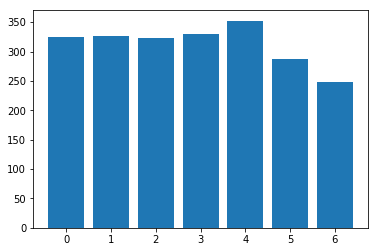

In [220]:
ser = df.groupby('day_of_week').mean()
import matplotlib.pyplot as plt
#plt.bar( ser['day_of_week'], ser['wait_sec'])
plt.bar( ser.index.values, ser['wait_sec'])
plt.show()




In [221]:
df['pickup_datetime'].describe()


count                   26374
unique                  25838
top       2017-01-21 07:43:00
freq                        4
first     2016-06-22 09:54:53
last      2017-08-01 12:51:34
Name: pickup_datetime, dtype: object

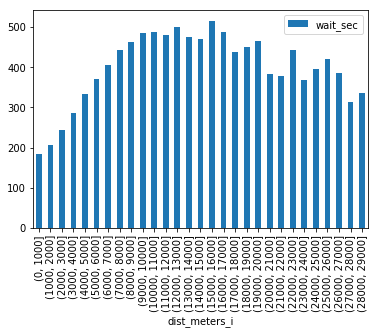

In [222]:
# let's investigation the relation of the distance and the wait time
distance =list(range(0, 30000, 1000))
len(distance)
#distance[59] =300000

df['dist_meters_i']= pd.cut(x=df['dist_meters'], bins=distance)

distance = df[['dist_meters_i','wait_sec']].groupby('dist_meters_i').mean()
distance.plot(kind='bar')




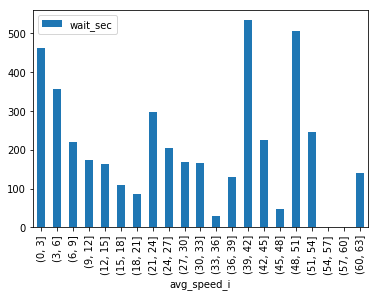

In [223]:

df['avg_speed'] = df['dist_meters'] / df['trip_duration'] 
df['avg_speed'].describe()
speed_s =list(range(0, 65, 3))
df['avg_speed_i']= pd.cut(x=df['avg_speed'], bins=speed_s)
speeds = df[['avg_speed_i','wait_sec']].groupby('avg_speed_i').mean()
speeds.plot(kind='bar')



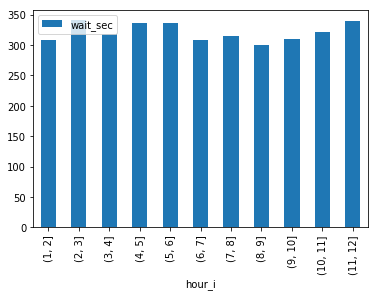

In [224]:

df['hour'].describe()
hours_s =list(range(1, 13))
hours_s
df['hour_i']= pd.cut(x=df['hour'], bins=hours_s)
hours= df[['hour_i','wait_sec']].groupby('hour_i').mean()
hours.plot(kind='bar')


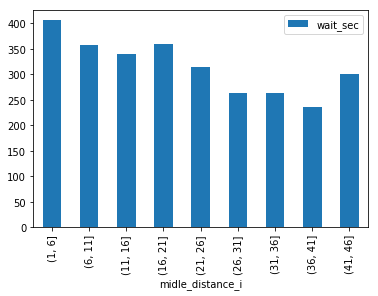

In [225]:
Quito_dowTown_latitude = -0.1909886 #-0.361363
Quito_dowTown_longitude = -78.4898697 #-78.492636
#  

df['midle_longitude']  = (df['pickup_longitude'] + df['dropoff_longitude']) /2 
df['midle_latitude']  = (df['pickup_latitude'] + df['dropoff_latitude']) /2 


df['midle_distance'] =  ((df['midle_latitude'] - Quito_dowTown_latitude)** 2) 
df['midle_distance'] =  (df['midle_distance'] +  ((df['midle_longitude'] - Quito_dowTown_longitude)** 2) ) ** 0.5
df['midle_distance'] =  100 * ( (df['midle_distance'] ) ** 0.5)
#df['midle_distance'].describe()

mid_dist_s =list(range(1, 50, 5))
df['midle_distance_i']= pd.cut(x=df['midle_distance'], bins=mid_dist_s)
mid_dists= df[['midle_distance_i','wait_sec']].groupby('midle_distance_i').mean()

mid_dists.plot(kind='bar')




In [226]:
# https://www.officeholidays.com/countries/ecuador/2017.php - holidays list of Ecuador
holidays = ['2016-01-01', '2016-02-08', '2016-02-09', '2016-03-25', '2016-03-27', 
            '2016-05-01', '2016-05-27', '2016-07-24', '2016-08-10', '2016-10-09', 
            '2016-11-02', '2016-11-03', '2016-12-06', '2016-12-25', 
            '2017-01-01', '2017-02-27', '2017-02-28', '2017-04-14', '2017-04-16', 
            '2017-05-01', '2017-05-24', '2017-07-24', '2017-08-10', '2017-10-09', 
            '2017-11-02', '2017-11-03', '2017-12-06', '2017-12-25']
holidays = pd.to_datetime(holidays)

df['isHoliday'] = 1*(pd.to_datetime(df['pickup_datetime'].dt.date).isin(holidays))


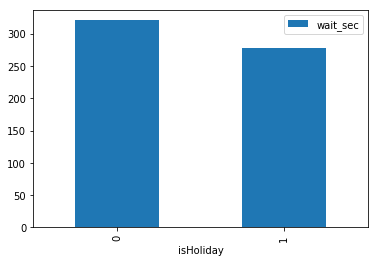

In [227]:
df['isHoliday'].describe()

isHoliday= df[['isHoliday','wait_sec']].groupby('isHoliday').mean()
isHoliday.plot(kind='bar')



# Input Cadidates

# Direct ones
<font color='RED'>id</font> -> is not necessary <br>
<font color='RED'>pickup_datetime</font>  for forecast the date will not repeat<br>
<font color='RED'>dropoff_datetime</font> for forecast the date will not repeat <br>
<font color='green'>pickup latitude and longitude</font>  Important  <br>
<font color='green'>dropoff latitude and longitude</font> Important <br>
<font color='RED'>store_and_fwd_flag </font> all records have the same value  <br>
<font color='blue'>trip_duration </font> It's important however this information is not available for before the trip <br>
<font color='green'>dist_meters </font>   Important  <br>


# Indirect ones    


<font color='green'>day_of_week  </font>  Important <br>
<font color='green'>pickup hour   </font>  Important  <br>
<font color='blue'>middle distance to downTown  </font> Cold be important  <br>
<font color='green'>holidays </font>  if it is holidays <br>
<font color='blue'>avg_speed </font> It's important however this information is not available for before the trip <br>

## trip_duration  and  avg_speed are important features however this information is not avalible for before the taxi ride. 
## Since I don't know if the prediction could be done after the trip. In a situation where I know the trip time but I don't know wating time. I have constructed two model one uses the avg_speed and other not.




In [228]:

from sklearn.model_selection import train_test_split

true_y = np.log1p(df['wait_sec'] )
#true_y =  df['wait_sec'] 



def getTrainingSet(usetripduration):
    X = df.drop(['id'], axis = 1)
    X = X.drop(['vendor_id'], axis = 1)
    X = X.drop(['pickup_datetime'], axis = 1)
    X = X.drop(['dropoff_datetime'], axis = 1)
    X = X.drop(['dist_meters_i'], axis = 1)
    X = X.drop(['avg_speed_i'], axis = 1)
    X = X.drop(['midle_distance_i'], axis = 1)
    X = X.drop(['hour_i'], axis = 1)
    
    
    X = X.drop(['wait_sec'], axis = 1)
    X = X.drop(['store_and_fwd_flag'], axis = 1)
    if (usetripduration == 0):
        X = X.drop(['trip_duration'], axis = 1)
        X = X.drop(['avg_speed'], axis = 1)
        
    #display(X.head(2))
    
   
    Xmatrix = X.as_matrix()
    
    return Xmatrix

Xmatrix = getTrainingSet(1)
#print(Xmatrix)
x_train, x_test, y_train, y_test = train_test_split(Xmatrix, true_y, test_size = 0.3, shuffle=True, random_state = 17)


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(18461, 16)
(7913, 16)
(18461,)
(7913,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Regretion  candidates 
    1. Linerar regretion Algorithms  -> These Algorithms not appear to be appropriate, there are many coreation in the problem that is not linear
    2. Neuron network - Could be a solution, however, since the problem has few input feature, probaly the shalow learnig  is more suitable.
    3 Decision Tree - could be too simple for the problem.
    4  Ensemble methods appears to be more aproprieted,  Randow florest and GradientBoosting are good  options.   
    
  

#  GradientBoostingRegressor Model  

In [229]:

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

def boostingRegretionGridResolve(X_train, y_train, X_test, y_test ):
    from sklearn.model_selection import GridSearchCV
       
    parameters = {
        "learning_rate": [0.04, 0.05, 0.07 ],
        "max_depth":[5,8, 12],
        "subsample":[0.4, 0.5, 0.7],
        "n_estimators":[200]
    }
    
    clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=4, n_jobs=-1)
    clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train))
    print(clf.best_params_)
    y_pre = clf.predict(X_train)
    y_pret_test = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pret_test)
    print("MSE: %.4f" % mse)
    return clf
        


Xmatrix = getTrainingSet(1) #withSpeed
x_train, x_test, y_train, y_test = train_test_split(Xmatrix, true_y, test_size = 0.3, shuffle=True, random_state = 17)
regretionwithSpeed = boostingRegretionGridResolve(x_train, y_train, x_test, y_test)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0.7268033372114038
{'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
MSE: 0.3387


In [231]:


# training without avg_speed
Xmatrix = getTrainingSet(0) # without avg_speed
x_train, x_test, y_train, y_test = train_test_split(Xmatrix, true_y, test_size = 0.3, shuffle=True, random_state = 17)
regretion = boostingRegretionGridResolve(x_train, y_train, x_test, y_test)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0.638342547105549
{'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.7}
MSE: 0.6700


#  RandomForestRegressor Model  

In [232]:

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def randonForestResolve(X_train, y_train, X_test, y_test ):
    from sklearn.model_selection import GridSearchCV
    
    
    # Set the parameters by cross-validation
    parameters = {'n_estimators': [50, 100, 200], 
                  'max_depth': [ 1, 2, 3, 8, 10, 20],
                  'min_samples_split': [0.1, 0.4, 0.7],
                  'min_samples_leaf': [1, 2, 4]
                 }

    # clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
    clf = GridSearchCV(ensemble.RandomForestRegressor(), parameters, cv=5,  n_jobs=-1, verbose=1)
    
    
    clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train))
    print(clf.best_params_)
    
    y_pre = clf.predict(X_train)
    y_pret_test = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pret_test)
    print("MSE: %.4f" % mse)
    
    return clf


Xmatrix = getTrainingSet(1)
x_train, x_test, y_train, y_test = train_test_split(Xmatrix, true_y, test_size = 0.3, shuffle=True, random_state = 17)
RandonRegretionWithSpeed = randonForestResolve(x_train, y_train, x_test, y_test)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  3.6min finished


0.5869235099748144
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100}
MSE: 0.4090


In [233]:
Xmatrix = getTrainingSet(0)
x_train, x_test, y_train, y_test = train_test_split(Xmatrix, true_y, test_size = 0.3, shuffle=True, random_state = 17)
RandonRegretion = randonForestResolve(x_train, y_train, x_test, y_test)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  3.2min finished


0.2514204322729269
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100}
MSE: 0.7434


In [253]:

def cacError(regretion, x, y, msg):
    y_pret_test = regretion.predict(x)
    mse = mean_squared_error(y, y_pret_test)
    print("MSE : %.4f" % mse, msg)
    
    
cacError(regretion, x_test, y_test, 'GradientBoosting test')   
cacError(regretion, x_train, y_train, 'GradientBoosting training')   


cacError(RandonRegretion, x_test, y_test, 'RandomForestRegressor test')   
cacError(RandonRegretion, x_train, y_train, 'RandomForestRegressor training')   



MSE : 0.6700 GradientBoosting test
MSE : 0.3546 GradientBoosting training
MSE : 0.7434 RandomForestRegressor test
MSE : 0.7340 RandomForestRegressor training


# Results
##  The folowing table compares  the erros rates  of the The GradientBoostingRegressor and RandomForestRegressor Algorithms using and not using  trip_duration and average speed (test error)
<br>
<table style="width:70%">
    
  <tr>
      <td> </td>
      <td><strong><font size="3" color="blue">GradientBoostingRegressor</font> </strong></td>
      <td><strong><font size="3" color="blue">RandomForestRegressor</font>  </strong></td>
  </tr>
  <tr>
      <td><strong>with trip_duration</strong>  </td>
      <td><strong>0.34</strong></td>
      <td><strong>0.40</strong> </td>
  </tr>
  <tr>
      <td><strong>without trip_duration</strong>  </td>
      <td><strong><font size="2" color="red">0.64</font>  </strong></td>
      <td><strong>0.74 </strong></td>
  </tr>
</table>


The models that use the trip_duration and average speed achieve better results. However, models that do not use the trip_duration and average speed could be  more useful, since these informations are not available for before the trip <br> 

The results show that GradientBoostingRegressor performed better than RandomForestRegressor, however 
the high difference between test and training errors using GradientBoostingRegressor indicates a high overfit.

To continue analysis let's go deeper into the <strong>RandomForestRegressor without trip_duration results</strong>. 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


MSE: 0.5756


In [54]:
# let's seen the crossValidation

def crossValidation(regretionmodel):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(regretionmodel, Xmatrix, true_y, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

crossValidation(RandonRegretion)


Accuracy: 0.31 (+/- 0.04)


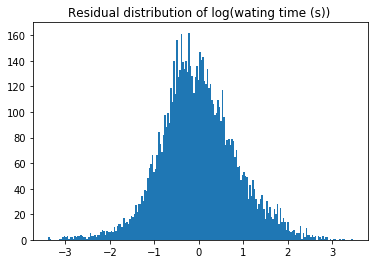

Predicted wating time mean for teste Dataset 5.3371
True wating time mean for teste Dataset  5.3499


In [236]:
# resudual distribution 

y_pre = RandonRegretion.predict(x_test)
#rest = ((y_pre - y_train)  * (y_pre - y_train) ** 0.5)
rest = (y_pre - y_test)  
rest.describe() 
plt.title('Residual distribution of log(wating time (s)) ')
plt.hist(rest, bins=200)  
plt.show()

print("Predicted wating time mean for teste Dataset %.4f" %  y_pre.mean() )
print("True wating time mean for teste Dataset  %.4f" % y_test.mean() )
                     
                      

In [250]:
#regretionfinal = regretion  # GradientBoostingRegressor
regretionfinal = RandonRegretion  # RandomForestRegressor


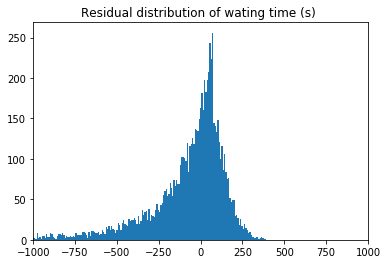

count    7913.000000
mean      -95.791493
std       294.397487
min     -2779.954591
25%      -168.682559
50%       -11.617785
75%        70.359789
max       393.373445
Name: wait_sec, dtype: float64


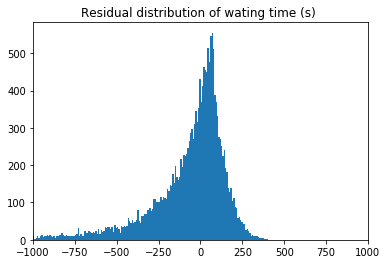

count    18461.000000
mean       -89.637639
std        292.073618
min      -2825.617785
25%       -161.489599
50%         -7.479156
75%         72.854119
max        405.401080
Name: wait_sec, dtype: float64


In [251]:
def calcRealErro(x, y, regretion):
    y_pre = np.expm1(regretion.predict(x))
    y_true= np.expm1(y)
    rest = (y_pre - y_true)  

    plt.title('Residual distribution of wating time (s) ')
    plt.hist(rest, bins=400)  
    plt.xlim(-1000, 1000)  
    plt.show()
    print(rest.describe() )
    
calcRealErro(x_test, y_test, regretionfinal)
calcRealErro(x_train, y_train, regretionfinal)


In [254]:




def calcRMSE(x, y, regretion, label):
    y_pre = np.expm1(regretion.predict(x))
    y_true= np.expm1(y)
    print(label,  ' RMSE error:  %.1f ' % np.sqrt(mean_squared_error(y_pre, y_true)), '(s)')

 
calcRMSE(x_test, y_test,regretionfinal, 'Test' )
calcRMSE(x_train, y_train,regretionfinal, 'training  ' )







Test  RMSE error:  309.6  (s)
training    RMSE error:  305.5  (s)
